<a href="https://colab.research.google.com/github/Tapeshsain07/BrainTumorDetection/blob/main/fastai_brain_tumor_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 1 - OpenCV**

In [1]:
import os
import cv2
import zipfile
from fastai.vision.all import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [3]:
parent_dir = Path("/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1")
parent_dir.ls()

(#3) [Path('/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset'),Path('/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/no'),Path('/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/yes')]

In [4]:
import os
import shutil
from pathlib import Path
import random

# Define the source and destination paths
source_path = Path('/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1')
destination_path = Path('./processed')

# Delete the directories first if exist and then create them
shutil.rmtree(destination_path, ignore_errors=True)

# Create the processed directory and subdirectories
(destination_path / 'train' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'train' / 'no').mkdir(parents=True, exist_ok=True)
(destination_path / 'valid' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'valid' / 'no').mkdir(parents=True, exist_ok=True)
(destination_path / 'test' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'test' / 'no').mkdir(parents=True, exist_ok=True)

# the following files are potentially mislabeled
# they need to be further investigated
potentially_mislabeled = [
    'no/28 no.jpg', 'yes/Y249.JPG', 'yes/Y252.jpg', 'yes/Y257.jpg', 'no/N15.jpg',
    'no/N16.jpg', 'yes/Y250.jpg', 'no/N11.jpg', 'yes/Y187.jpg', 'no/N1.JPG', 'no/N19.JPG'
]
potentially_mislabeled = [source_path / p for p in potentially_mislabeled]

# Function to split and move files
def split_and_move_files(category):
    files = list((source_path / category).glob('*'))
    # exclude potentially mislabeled files
    files = [f for f in files if f not in potentially_mislabeled]
    random.shuffle(files)

    train_split = int(0.8 * len(files))
    valid_split = int(0.1 * len(files))

    train_files = files[:train_split]
    valid_files = files[train_split:train_split + valid_split]
    test_files = files[train_split + valid_split:]

    for f in train_files:
        shutil.copy(str(f), str(destination_path / 'train' / category / f.name))
    for f in valid_files:
        shutil.copy(str(f), str(destination_path / 'valid' / category / f.name))
    for f in test_files:
        shutil.copy(str(f), str(destination_path / 'test' / category / f.name))

# Split and copy files for 'yes' and 'no' categories
split_and_move_files('yes')
split_and_move_files('no')

print("Files split and moved successfully.")

Files split and moved successfully.


In [5]:
tumour_images=[]
for name in glob.glob('/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1*.jpg'):
    image = cv2.imread(name)
    image = cv2.resize(image,(240,240))
    tumour_images.append(image)

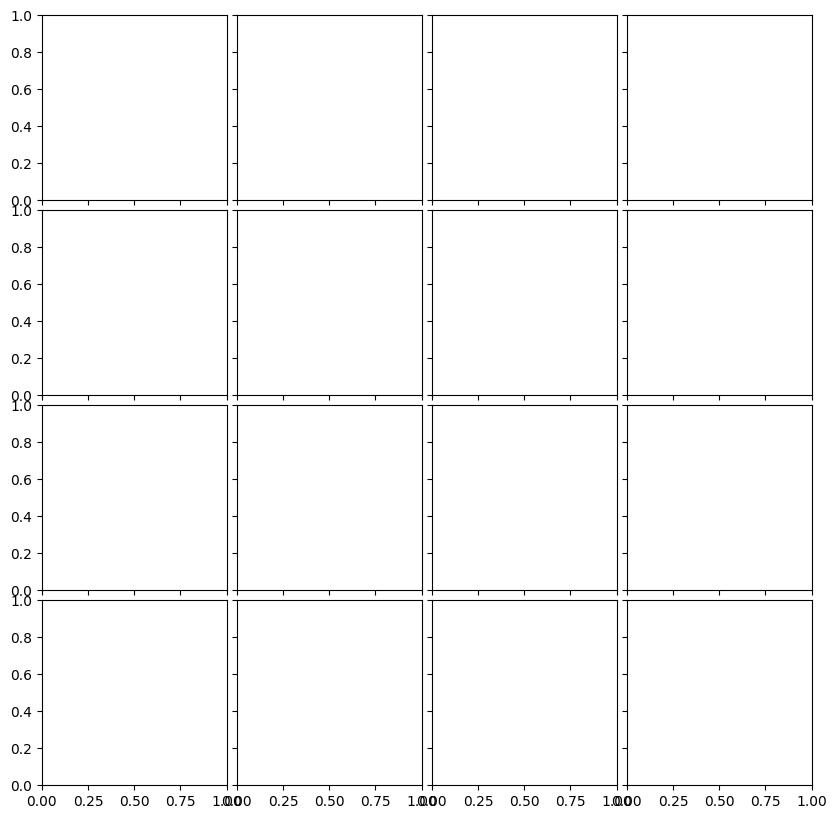

In [6]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),  axes_pad=0.1,   )
for ax, im in zip(grid, tumour_images[0:16]):
    ax.imshow(im)
plt.show()

In [7]:
img_path = "/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/yes/Y104.jpg"
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(500,590)
image=cv2.resize(image, dim)

width: 700 pixels
height: 890 pixels
channels: 3


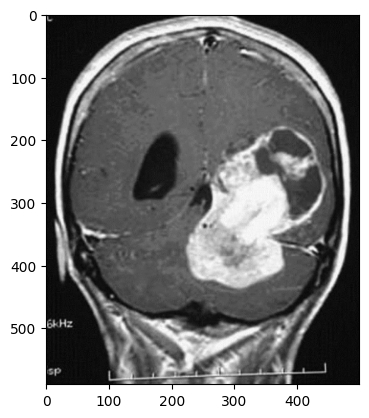

In [8]:
plt.imshow(image)

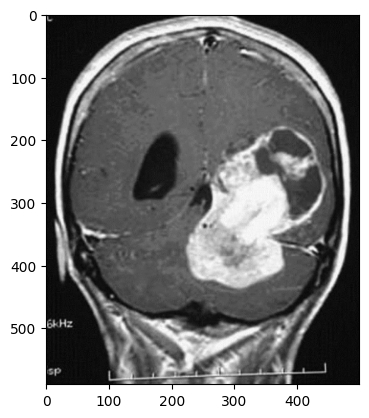

In [9]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(image)


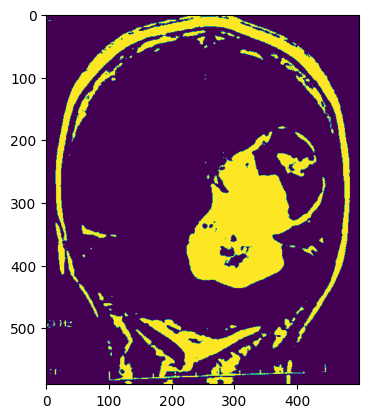

In [10]:
(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)


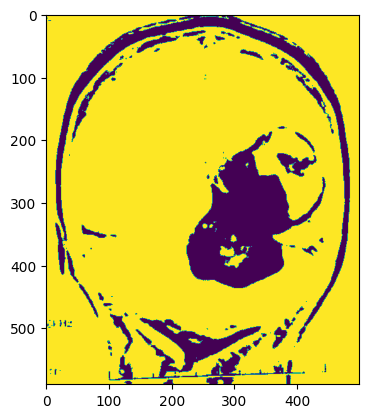

In [11]:
(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv)


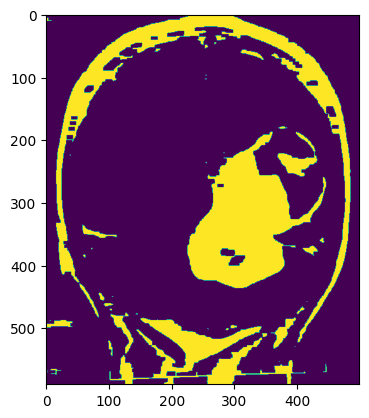

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)

In [13]:
closed = cv2.erode(closed, None, iterations = 19)
closed = cv2.dilate(closed, None, iterations = 17)

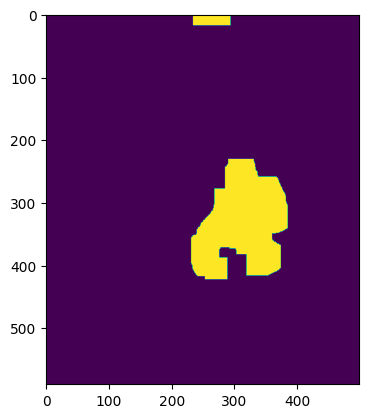

In [14]:
plt.imshow(closed)

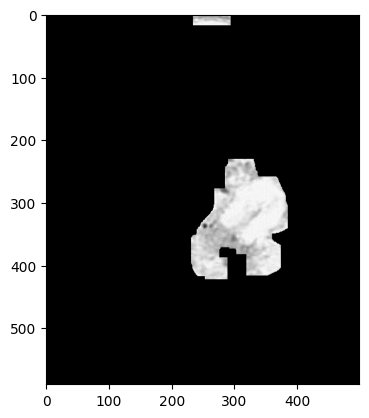

In [15]:
ret,mask = cv2.threshold(closed, 155, 255, cv2.THRESH_BINARY)
#apply AND operation on image and mask generated by thrresholding
final = cv2.bitwise_and(image,image,mask = mask)
plt.imshow(final)

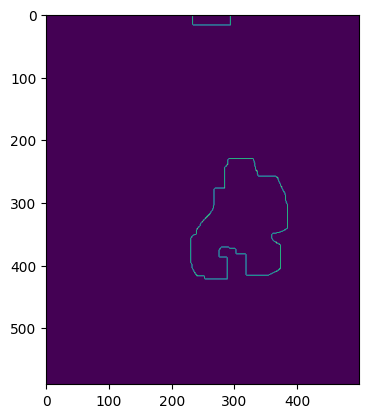

In [16]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

canny = auto_canny(closed)
plt.imshow(canny)

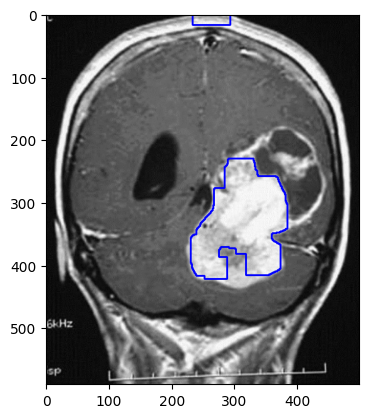

In [17]:
(cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
plt.imshow(image)

# **Part 2 - FastAI**

In [18]:
import numpy as np
import pandas as pd
import os,gc,pathlib
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import torchvision.models as models
from pathlib import Path

print(os.listdir("/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1"))

['brain_tumor_dataset', 'no', 'yes']


In [19]:
DATA_DIR= Path('./processed/')

In [20]:
os.listdir(f'{DATA_DIR}')

['valid', 'test', 'train']

In [21]:
from fastai.vision.all import *

batch_tfms = [
    *aug_transforms(
        size=224,
        mult=1.0,
        do_flip=True,
        flip_vert=False,
        max_rotate= 10.0,
        min_zoom= 1.0,
        max_zoom= 1.0,
        max_lighting= 0.2,
        max_warp= 0.2,
        p_affine= 0.75,
        p_lighting= 0.75,
        xtra_tfms= None,
        mode='bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.1,
        ),
    Normalize.from_stats(*imagenet_stats)]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
).dataloaders(DATA_DIR, bs=16)

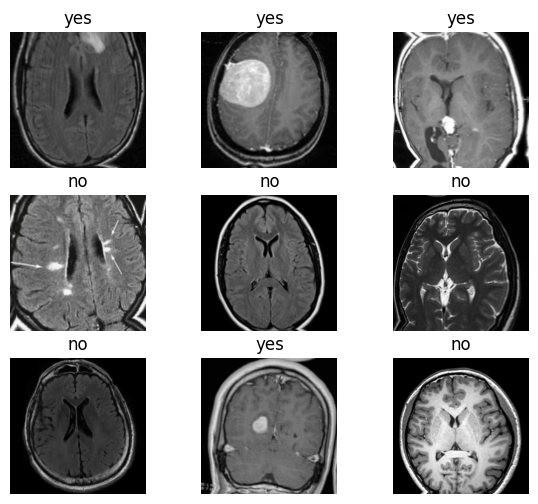

In [22]:
dls.show_batch(figsize=(7,6))

In [23]:
import timm

def get_learner(model_name='xresnet50', patience=3, bs=16):
    # Create the model based on the no of classes in the data coming from the dataloaders dls.c
    the_model = timm.create_model(model_name, pretrained=True, num_classes=dls.c)

    # Wrap the model with DataParallel for multi-GPU training
    if torch.cuda.device_count() > 1:
        the_model = torch.nn.DataParallel(the_model)

    # Create the Learner
    learner = Learner(
        dls,
        the_model,
        metrics=accuracy,
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', patience=patience),
            SaveModelCallback(monitor='valid_loss', fname=f'{model_name}_best_model')
        ]
    )

    learner.dls.bs = bs

    return learner

Slide: 0.00363078061491251
Valley: 6.918309736647643e-06
Minimum: 1.0964782268274575e-05
Steep: 8.31763736641733e-06


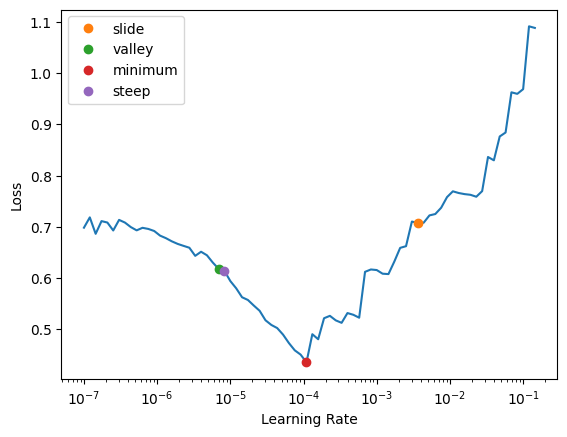

In [24]:
PERFORM_EXPORT = True
model_name='convnext_tiny'
learner = get_learner(model_name=model_name, patience=8)
lr_slide, lr_valley, lr_min, lr_steep = learner \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))

# Display all the learning rates
print(f"Slide: {lr_slide}")
print(f"Valley: {lr_valley}")
print(f"Minimum: {lr_min}")
print(f"Steep: {lr_steep}")

epoch,train_loss,valid_loss,accuracy,time
0,0.655235,0.566947,0.791667,02:18
1,0.589072,0.426464,0.833333,02:22
2,0.495998,0.263291,0.916667,02:16
3,0.403937,0.134867,0.958333,02:17
4,0.330229,0.112734,1.000000,02:15
5,0.268455,0.120950,0.958333,02:16
6,0.214111,0.072586,0.958333,02:15
7,0.170840,0.077161,0.958333,02:23
8,0.135058,0.039130,1.000000,02:17
9,0.107882,0.034162,1.000000,02:16


Better model found at epoch 0 with valid_loss value: 0.5669474005699158.
Better model found at epoch 1 with valid_loss value: 0.42646387219429016.
Better model found at epoch 2 with valid_loss value: 0.26329120993614197.
Better model found at epoch 3 with valid_loss value: 0.13486729562282562.
Better model found at epoch 4 with valid_loss value: 0.11273449659347534.
Better model found at epoch 6 with valid_loss value: 0.07258591800928116.
Better model found at epoch 8 with valid_loss value: 0.039130453020334244.
Better model found at epoch 9 with valid_loss value: 0.03416247293353081.
Better model found at epoch 13 with valid_loss value: 0.02602885663509369.
Better model found at epoch 14 with valid_loss value: 0.02474725991487503.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

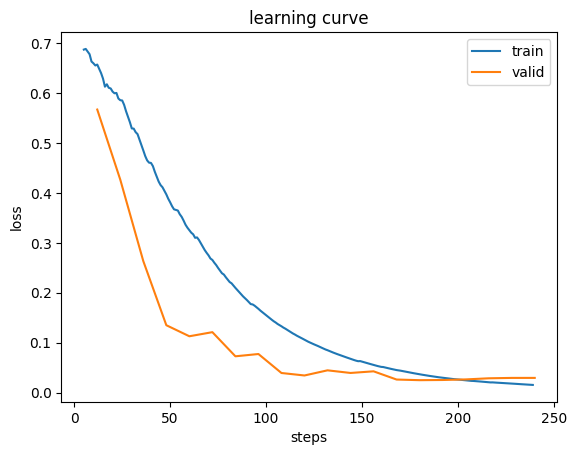

In [25]:
learner.freeze()
learner.fit_one_cycle(20, lr_valley)

learner.recorder.plot_loss()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

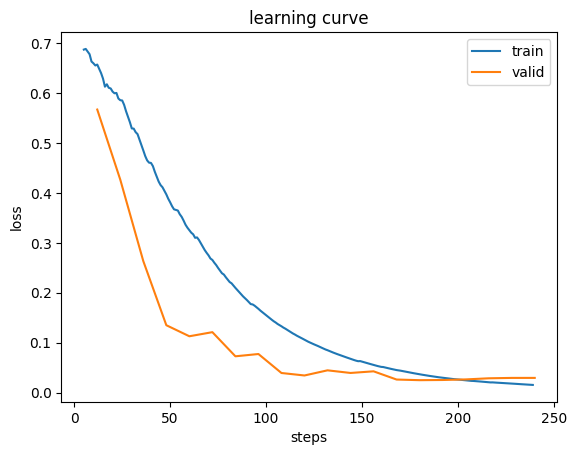

In [26]:
learner.recorder.plot_loss()

In [27]:
interp = ClassificationInterpretation.from_learner(learner)

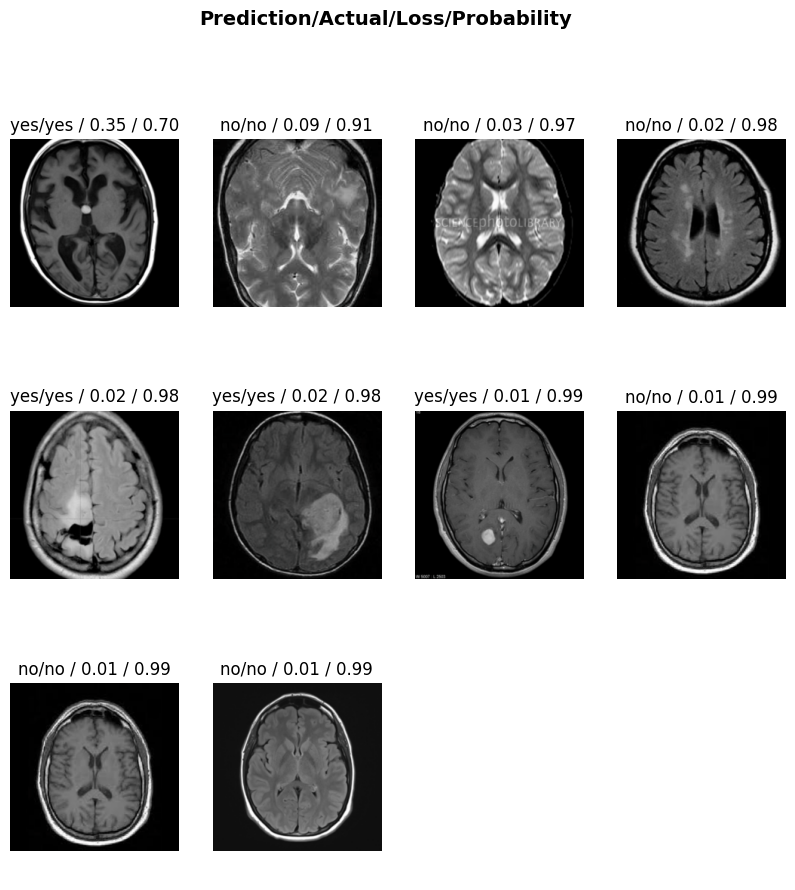

In [28]:
interp.plot_top_losses(10, figsize=(10,10))

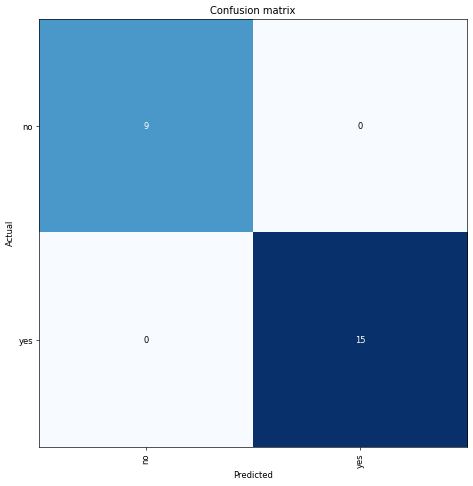

In [29]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [30]:
# Get the top losses
losses, idxs = interp.top_losses()

# Assuming the dataset has a method to retrieve the filenames
top_confused_files = [dls.valid_ds.items[i] for i in idxs]
print(top_confused_files)

[Path('processed/valid/yes/Y188.jpg'), Path('processed/valid/no/N6.jpg'), Path('processed/valid/no/46 no.jpg'), Path('processed/valid/no/no 8.jpg'), Path('processed/valid/yes/Y168.jpg'), Path('processed/valid/yes/Y23.JPG'), Path('processed/valid/yes/Y6.jpg'), Path('processed/valid/no/40 no.jpg'), Path('processed/valid/no/41 no.jpg'), Path('processed/valid/no/no.jpg'), Path('processed/valid/no/11 no.jpg'), Path('processed/valid/no/1 no.jpeg'), Path('processed/valid/yes/Y32.jpg'), Path('processed/valid/yes/Y62.jpg'), Path('processed/valid/yes/Y91.jpg'), Path('processed/valid/yes/Y10.jpg'), Path('processed/valid/no/4 no.jpg'), Path('processed/valid/yes/Y86.JPG'), Path('processed/valid/yes/Y58.JPG'), Path('processed/valid/yes/Y79.jpg'), Path('processed/valid/yes/Y169.jpg'), Path('processed/valid/yes/Y116.JPG'), Path('processed/valid/yes/Y25.jpg'), Path('processed/valid/yes/Y182.JPG')]


In [31]:
from fastai.vision.all import *

# Load the test set
test_files = get_image_files(DATA_DIR/'test')
test_dl = dls.test_dl(test_files)

# Get predictions on the test set from the best trained model weights
learner.load(f'{model_name}_best_model')
preds, _ = learner.get_preds(dl=test_dl)

# Get the actual labels from the folder names and convert to tensor
test_labels = tensor([dls.vocab.o2i[parent_label(f)] for f in test_files])

# Calculate the accuracy
predicted_labels = preds.argmax(dim=1)
accuracy = (predicted_labels == test_labels).float().mean()

# Print the accuracy
print(f"Test set accuracy: {accuracy:.4f}")

Test set accuracy: 0.9200


In [32]:
incorrect_predictions = (predicted_labels != test_labels)
incorrect_files = [f for i, f in enumerate(test_files) if incorrect_predictions[i]]
print(incorrect_files)

[Path('processed/test/no/N22.JPG'), Path('processed/test/no/N20.JPG')]


In [33]:
incorrect_predictions = (predicted_labels != test_labels)
incorrect_files = [f for i, f in enumerate(test_files) if incorrect_predictions[i]]
print(incorrect_files)

[Path('processed/test/no/N22.JPG'), Path('processed/test/no/N20.JPG')]


In [34]:
if PERFORM_EXPORT:
    learner.export(f'{model_name}.pkl')